In [1]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from copy import deepcopy

from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.transforms import Lambda
from torchvision.transforms import Compose, ToTensor

import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn

from typing import Tuple
from typing import List
from copy import deepcopy, copy

In [2]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import os

In [3]:
## hyperparameters:
num_epochs = 10
batch_size = 1000
learning_rate = 0.001

### Load dataset: MNIST

In [4]:
train_dataset = MNIST(
    root='.',
    download=True,
    train=True, 
    )

test_dataset = MNIST(
    root='.',
    download=True,
    train=False, 
)


train_dataset.data = (train_dataset.data/255.0)  
test_dataset.data = (test_dataset.data/255.0)


def calculate_mean_and_std() -> Tuple[float, float]:
    mean = train_dataset.data.mean()
    std = train_dataset.data.std()
    return mean, std

mean, std = calculate_mean_and_std()

In [5]:
transform = transforms.Compose([
        transforms.ToTensor(), 
        #transforms.Lambda(lambda x: x.view(28,28)),
        transforms.Lambda(lambda x: (x-mean)/std),       
]) 


train_dataset = MNIST(
    root = '.', 
    download = True, 
    train = True, 
    transform = transform
)

test_dataset = MNIST(
    root='.',
    download=True,
    train=False, 
    transform = transform
)

In [6]:
train_loader  = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                         batch_size=batch_size,
                                         shuffle=True)


In [7]:
x,y = next(iter(train_loader))
#assert len(x.shape) == 4
#assert x.shape == (100, 1, 28,28)

print(x.shape)
print(y.shape)

print("Checking, whether normalization in transforms is working.")

for i in range(100):
    if i%7==0:
        print("Sample image in bath size:\t mean(x) = {:}\t std(x)={:}".format(x[i].mean(), x[i].std()))

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
Checking, whether normalization in transforms is working.
Sample image in bath size:	 mean(x) = -0.1669987589120865	 std(x)=0.7772389650344849
Sample image in bath size:	 mean(x) = 0.11545051634311676	 std(x)=1.0766876935958862
Sample image in bath size:	 mean(x) = 0.026273908093571663	 std(x)=1.0131289958953857
Sample image in bath size:	 mean(x) = 0.13533784449100494	 std(x)=1.134533166885376
Sample image in bath size:	 mean(x) = 0.19215869903564453	 std(x)=1.1865630149841309
Sample image in bath size:	 mean(x) = 0.04999269172549248	 std(x)=1.0453811883926392
Sample image in bath size:	 mean(x) = -0.04233338311314583	 std(x)=0.9469925761222839
Sample image in bath size:	 mean(x) = 0.04065779596567154	 std(x)=1.0308281183242798
Sample image in bath size:	 mean(x) = 0.2721627354621887	 std(x)=1.2374012470245361
Sample image in bath size:	 mean(x) = 0.21128308773040771	 std(x)=1.1802409887313843
Sample image in bath size:	 mean(x) = -0.22

## Model

nn.conv2d=

        in_channels (int) – Number of channels in the input image

        out_channels (int) – Number of channels produced by the convolution

        kernel_size (int or tuple) – Size of the convolving kernel

        stride (int or tuple, optional) – Stride of the convolution. Default: 1

        padding (int or tuple, optional) – Zero-padding added to both sides of the input. Default: 0

        padding_mode (string, optional) – 'zeros', 'reflect', 'replicate' or 'circular'. Default: 'zeros'

        dilation (int or tuple, optional) – Spacing between kernel elements. Default: 1

        groups (int, optional) – Number of blocked connections from input channels to output channels. Default: 1

        bias (bool, optional) – If True, adds a learnable bias to the output. Default: True



In [8]:
class CNN_small(nn.Module):
    def __init__(self):
        super(CNN_small, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5, padding=0), #1 * 28 * 28 -> 8 * 24 * 24
            nn.BatchNorm2d(8),                         #8 * 24 * 24
            nn.ReLU())                                 #8 * 24 * 24
        
        self.layer2  = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=5, padding=0), # 8 * 24 * 24 -> 16 * 20* 20
            nn.BatchNorm2d(16),                         #16 * 20 * 20
            nn.ReLU())                                  #16 * 20 * 20
        
        self.fc = nn.Linear(16 * 20 * 20, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    
model = CNN_small()

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5, padding=2), #1 * 28 * 28 -> 8 * 28 * 28
            nn.BatchNorm2d(8),                         #8 * 28 * 28
            nn.ReLU())                                 #8 * 28 * 28
            #nn.MaxPool2d(2))       
        
        self.layer2  = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=5, padding=2), # 8 * 28 * 28 -> 16 * 28* 28
            nn.BatchNorm2d(16),                         #16 * 28 * 28
            nn.ReLU())                                  #16 * 28 * 28
            #nn.MaxPool2d(2))       
        
        self.fc = nn.Linear(16 * 28 * 28, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    
model = CNN()

## Train the model

In [10]:
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images)
        labels = Variable(labels)
            
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
            
        if (i+1) % 100 == 0:
            print("epoch, ",epoch,"loss - ", loss, )
    print("epoch, ",epoch,"loss - ", loss, )

epoch,  0 loss -  tensor(0.1451, grad_fn=<NllLossBackward>)
epoch,  1 loss -  tensor(0.0791, grad_fn=<NllLossBackward>)
epoch,  2 loss -  tensor(0.0626, grad_fn=<NllLossBackward>)
epoch,  3 loss -  tensor(0.0414, grad_fn=<NllLossBackward>)
epoch,  4 loss -  tensor(0.0221, grad_fn=<NllLossBackward>)
epoch,  5 loss -  tensor(0.0343, grad_fn=<NllLossBackward>)
epoch,  6 loss -  tensor(0.0301, grad_fn=<NllLossBackward>)
epoch,  7 loss -  tensor(0.0220, grad_fn=<NllLossBackward>)
epoch,  8 loss -  tensor(0.0138, grad_fn=<NllLossBackward>)
epoch,  9 loss -  tensor(0.0152, grad_fn=<NllLossBackward>)


## Test the model

In [11]:
# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
       # images = images.to(device)
       # labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy of the model on the 10000 test images: 98.64 %


In [12]:
PATH = './model.pth'
torch.save(model.state_dict(), PATH)

## Model Paramteres, weights and so on

In [13]:
print("Model's state_dict:")

for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

print()

Model's state_dict:
layer1.0.weight 	 torch.Size([8, 1, 5, 5])
layer1.0.bias 	 torch.Size([8])
layer1.1.weight 	 torch.Size([8])
layer1.1.bias 	 torch.Size([8])
layer1.1.running_mean 	 torch.Size([8])
layer1.1.running_var 	 torch.Size([8])
layer1.1.num_batches_tracked 	 torch.Size([])
layer2.0.weight 	 torch.Size([16, 8, 5, 5])
layer2.0.bias 	 torch.Size([16])
layer2.1.weight 	 torch.Size([16])
layer2.1.bias 	 torch.Size([16])
layer2.1.running_mean 	 torch.Size([16])
layer2.1.running_var 	 torch.Size([16])
layer2.1.num_batches_tracked 	 torch.Size([])
fc.weight 	 torch.Size([10, 12544])
fc.bias 	 torch.Size([10])



In [14]:
for param_tensor in model.state_dict():
    print("\n\n\n",  model.state_dict()[param_tensor])





 tensor([[[[-0.0759,  0.0487,  0.1627,  0.0699, -0.0248],
          [ 0.1798, -0.0290,  0.1644, -0.1599,  0.0678],
          [ 0.1376,  0.0257, -0.1042, -0.1645, -0.0962],
          [ 0.0095,  0.1079,  0.0114, -0.0978,  0.0887],
          [ 0.0188,  0.0047, -0.0642, -0.1813, -0.1474]]],


        [[[ 0.0707, -0.0698,  0.0512, -0.0010, -0.0389],
          [ 0.0920, -0.0239, -0.1559,  0.1618,  0.1338],
          [-0.0602, -0.0102,  0.1800, -0.0139, -0.1545],
          [-0.0899, -0.0427,  0.0067,  0.1084, -0.0641],
          [-0.0965,  0.0968,  0.0927,  0.1107, -0.2168]]],


        [[[ 0.1630,  0.1460,  0.0272,  0.2347,  0.0579],
          [ 0.0011,  0.0566, -0.0455, -0.1168,  0.0183],
          [-0.1897, -0.0188, -0.0242, -0.1700, -0.0303],
          [-0.0376, -0.1020,  0.0887, -0.1878,  0.0098],
          [-0.0184, -0.1375, -0.0410,  0.1302, -0.0553]]],


        [[[-0.1307,  0.1214, -0.1083, -0.0127, -0.1789],
          [ 0.0293,  0.1362, -0.1467, -0.0620,  0.0009],
          [ 0.0

## Get inside

In [25]:
class CNN_layer1(nn.Module):
    def __init__(self):
        super(CNN_layer1, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5, padding=2), #1 * 28 * 28 -> 8 * 28 * 28
            nn.BatchNorm2d(8),                         #8 * 28 * 28
            nn.ReLU())                                 #8 * 28 * 28
        
        self.layer2  = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=5, padding=2), # 8 * 28 * 28 -> 16 * 28* 28
            nn.BatchNorm2d(16),                         #16 * 28 * 28
            nn.ReLU())                                  #16 * 28 * 28
        
        self.fc = nn.Linear(16 * 28 * 28, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        return out


class CNN_layer2(nn.Module):
    def __init__(self):
        super(CNN_layer2, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5, padding=2), #1 * 28 * 28 -> 8 * 28 * 28
            nn.BatchNorm2d(8),                         #8 * 28 * 28
            nn.ReLU())                                 #8 * 28 * 28
            #nn.MaxPool2d(2))       
        
        self.layer2  = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=5, padding=2), # 8 * 28 * 28 -> 16 * 28* 28
            nn.BatchNorm2d(16),                         #16 * 28 * 28
            nn.ReLU())                                  #16 * 28 * 28
        
        self.fc = nn.Linear(16 * 28 * 28, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        return out

In [34]:
model.eval()

PATH = './model.pth'
torch.save(model.state_dict(), PATH)

In [37]:
layer1 = CNN_layer1()
layer1.load_state_dict(torch.load(PATH))
layer1.eval()

layer2 = CNN_layer2()
layer2.load_state_dict(torch.load(PATH))
layer2.eval()

CNN_layer2(
  (layer1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fc): Linear(in_features=12544, out_features=10, bias=True)
)

In [38]:
print("Layer1's state_dict:")

for param_tensor in layer1.state_dict():
    print(param_tensor, "\t", layer1.state_dict()[param_tensor].size())

print()

Layer1's state_dict:
layer1.0.weight 	 torch.Size([8, 1, 5, 5])
layer1.0.bias 	 torch.Size([8])
layer1.1.weight 	 torch.Size([8])
layer1.1.bias 	 torch.Size([8])
layer1.1.running_mean 	 torch.Size([8])
layer1.1.running_var 	 torch.Size([8])
layer1.1.num_batches_tracked 	 torch.Size([])
layer2.0.weight 	 torch.Size([16, 8, 5, 5])
layer2.0.bias 	 torch.Size([16])
layer2.1.weight 	 torch.Size([16])
layer2.1.bias 	 torch.Size([16])
layer2.1.running_mean 	 torch.Size([16])
layer2.1.running_var 	 torch.Size([16])
layer2.1.num_batches_tracked 	 torch.Size([])
fc.weight 	 torch.Size([10, 12544])
fc.bias 	 torch.Size([10])



In [39]:
print("Layer2's state_dict:")

for param_tensor in layer1.state_dict():
    print(param_tensor, "\t", layer1.state_dict()[param_tensor].size())

print()

Layer2's state_dict:
layer1.0.weight 	 torch.Size([8, 1, 5, 5])
layer1.0.bias 	 torch.Size([8])
layer1.1.weight 	 torch.Size([8])
layer1.1.bias 	 torch.Size([8])
layer1.1.running_mean 	 torch.Size([8])
layer1.1.running_var 	 torch.Size([8])
layer1.1.num_batches_tracked 	 torch.Size([])
layer2.0.weight 	 torch.Size([16, 8, 5, 5])
layer2.0.bias 	 torch.Size([16])
layer2.1.weight 	 torch.Size([16])
layer2.1.bias 	 torch.Size([16])
layer2.1.running_mean 	 torch.Size([16])
layer2.1.running_var 	 torch.Size([16])
layer2.1.num_batches_tracked 	 torch.Size([])
fc.weight 	 torch.Size([10, 12544])
fc.bias 	 torch.Size([10])



In [40]:
model.state_dict()['layer1.0.bias']

tensor([ 0.0350, -0.1326, -0.0275, -0.0547, -0.0174,  0.0831, -0.1906, -0.0324])

## See pictures layer after layer

In [70]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                         batch_size=1,
                                         shuffle=True)
x,y = next(iter(test_loader))

torch.Size([28, 28]) torch.Size([28, 28]) torch.Size([28, 28])


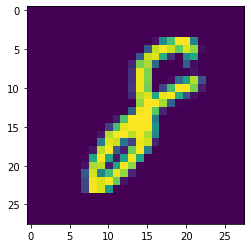

In [82]:
outputs1 = layer1(x)
outputs1.size()

outputs2 = layer2(x)
outputs2.size()

image = x[0][0]
image.size()

image1 = outputs1[0][0]
image2 = outputs2[0][0]

image1.detach().numpy()
image2.detach().numpy()

print(image.size(), image1.size(), image2.size())

plt.imshow(image)


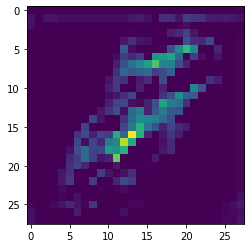

In [85]:
plt.imshow(image2.detach().numpy())
